In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 1. CONFIGURATION

In [3]:
PROCESSED_DIR = Path('../data/processed')
FEATURES_DIR = Path('../data/features')
FEATURES_DIR.mkdir(exist_ok=True)

# Charger les splits
df_splits = pd.read_csv(PROCESSED_DIR / 'dataset_splits.csv')
print(f"\n📊 Dataset: {len(df_splits)} images, {df_splits['label'].nunique()} classes")



📊 Dataset: 1907 images, 32 classes


# 2. FONCTIONS D'EXTRACTION DE FEATURES

In [4]:
def extract_shape_features(img_gray):
    """
    Extrait des features de FORME (shape descriptors)
    
    Features extraites:
    - Area (aire)
    - Perimeter (périmètre)
    - Aspect Ratio (ratio largeur/hauteur)
    - Extent (rapport area/bounding box)
    - Solidity (rapport area/convex hull)
    - Compactness (circularité)
    
    Returns:
        dict avec 6 features
    """
    # Binarisation (seuillage d'Otsu)
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Inverser si fond blanc
    if np.mean(binary) > 127:
        binary = cv2.bitwise_not(binary)
    
    # Trouver contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return {f'shape_{i}': 0 for i in range(6)}
    
    # Prendre le plus grand contour (la feuille)
    cnt = max(contours, key=cv2.contourArea)
    
    # Area
    area = cv2.contourArea(cnt)
    
    # Perimeter
    perimeter = cv2.arcLength(cnt, True)
    
    # Bounding box
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # Extent
    rect_area = w * h
    extent = float(area) / rect_area if rect_area > 0 else 0
    
    # Convex hull
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0
    
    # Compactness (circularité)
    compactness = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    
    return {
        'shape_0': area / 10000,  # Normaliser
        'shape_1': perimeter / 1000,
        'shape_2': aspect_ratio,
        'shape_3': extent,
        'shape_4': solidity,
        'shape_5': compactness
    }


def extract_color_features(img_rgb):
    """
    Extrait des features de COULEUR (color moments)
    
    Features extraites (pour chaque canal RGB):
    - Mean (moyenne)
    - Std (écart-type)
    - Skewness (asymétrie)
    
    Returns:
        dict avec 9 features (3 canaux × 3 moments)
    """
    features = {}
    
    for i, channel_name in enumerate(['R', 'G', 'B']):
        channel = img_rgb[:, :, i].flatten()
        
        # Moments
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean(((channel - mean) / std) ** 3) if std > 0 else 0
        
        features[f'color_{i*3+0}'] = mean / 255
        features[f'color_{i*3+1}'] = std / 255
        features[f'color_{i*3+2}'] = skewness
    
    return features


def extract_texture_features(img_gray):
    """
    Extrait des features de TEXTURE (Haralick via GLCM simplifiée)
    
    Features extraites:
    - Contraste (différences de niveaux de gris)
    - Homogénéité (Local Gray Level Uniformity - LBP)
    - Entropie (désordre)
    - Énergie (uniformité)
    
    Returns:
        dict avec 4 features
    """
    # Calculer histogramme
    hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
    hist = hist.flatten() / hist.sum()
    
    # Entropie
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    
    # Énergie
    energy = np.sum(hist ** 2)
    
    # Calculer gradient (Sobel) pour contraste
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    contrast = np.mean(gradient_magnitude) / 255
    
    # LBP simplifié (homogénéité)
    lbp = cv2.Laplacian(img_gray, cv2.CV_64F)
    homogeneity = 1 / (1 + np.std(lbp))
    
    return {
        'texture_0': contrast,
        'texture_1': homogeneity,
        'texture_2': entropy / 8,  # Normaliser
        'texture_3': energy
    }


def extract_all_features(img_path):
    """
    Extrait TOUTES les features d'une image
    
    Returns:
        dict avec 19 features:
        - 6 shape features
        - 9 color features
        - 4 texture features
    """
    # Charger image
    img_rgb = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    # Extraire features
    features = {}
    features.update(extract_shape_features(img_gray))
    features.update(extract_color_features(img_rgb))
    features.update(extract_texture_features(img_gray))
    
    return features

# 3. EXTRAIRE FEATURES POUR TOUT LE DATASET

In [5]:

all_features = []

for idx, row in tqdm(df_splits.iterrows(), total=len(df_splits), desc="Extracting"):
    filename = row['filename']
    label = row['label']
    split = row['split']
    
    # Trouver le chemin de l'image preprocessed
    img_path = PROCESSED_DIR / split / f'class_{label:02d}' / filename
    
    # Extraire features
    features = extract_all_features(img_path)
    features['filename'] = filename
    features['label'] = label
    features['split'] = split
    
    all_features.append(features)

# Créer DataFrame
df_features = pd.DataFrame(all_features)

print(f"\n Features extraites: {df_features.shape}")
print(f"   Colonnes: {df_features.shape[1]} (19 features + 3 metadata)")


Extracting: 100%|██████████| 1907/1907 [00:24<00:00, 77.88it/s]


 Features extraites: (1907, 22)
   Colonnes: 22 (19 features + 3 metadata)


# 4. VISUALISER LES FEATURES


📊 Statistiques des features:
           shape_0      shape_1      shape_2      shape_3      shape_4  \
count  1907.000000  1907.000000  1907.000000  1907.000000  1907.000000   
mean      1.701771     0.642354     1.197965     0.528494     0.914687   
std       0.987958     0.146998     0.444284     0.206973     0.116532   
min       0.083150     0.287522     0.614634     0.025808     0.410657   
25%       1.083975     0.564675     1.000000     0.396726     0.918781   
50%       1.635950     0.627269     1.084656     0.567253     0.961006   
75%       2.124225     0.695352     1.243332     0.641737     0.977535   
max       4.972900     1.557346     7.045455     0.991091     1.000000   

           shape_5      color_0      color_1      color_2      color_3  \
count  1907.000000  1907.000000  1907.000000  1907.000000  1907.000000   
mean      0.514498     0.773960     0.310677    -1.081145     0.871469   
std       0.202589     0.093024     0.064292     1.171767     0.062681   
min    

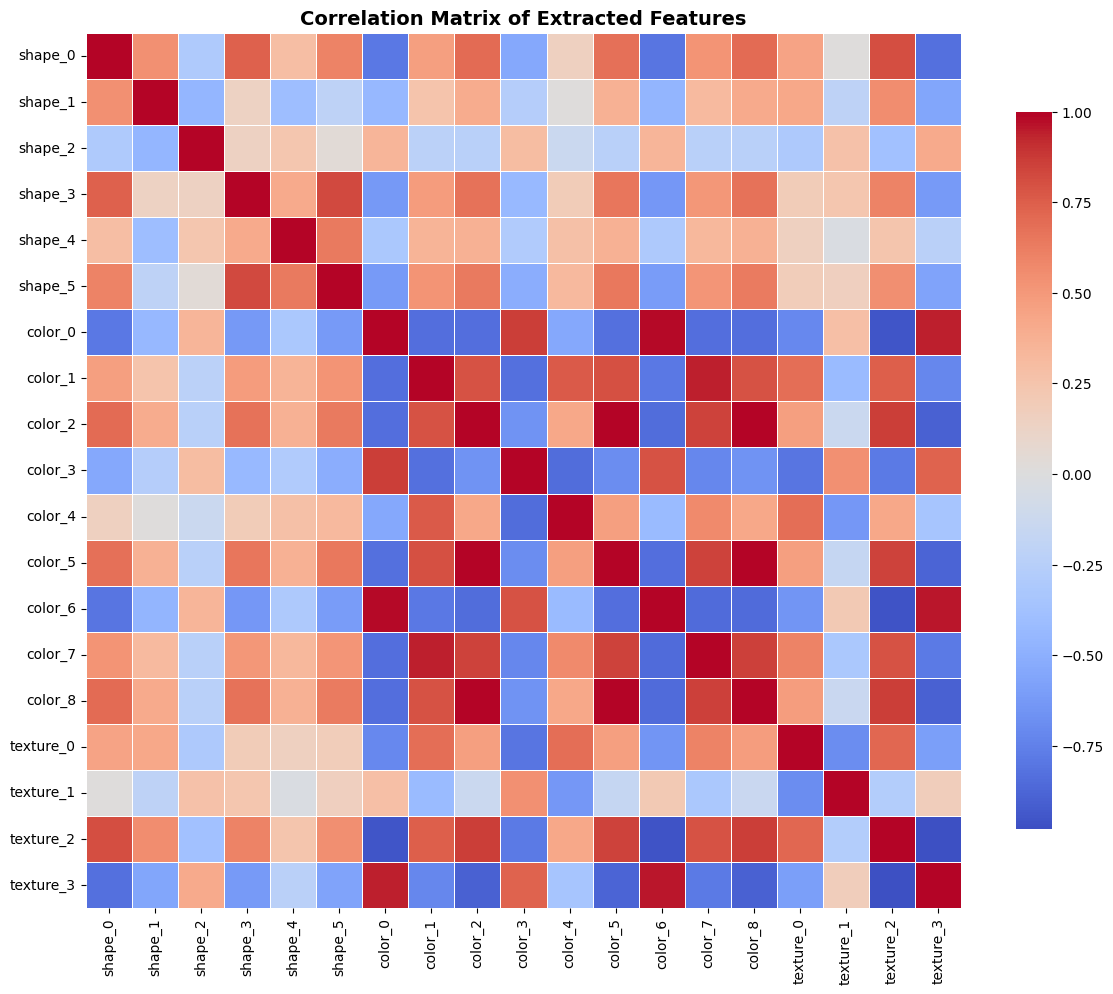

In [6]:
# Sélectionner uniquement les features (exclure metadata)
feature_cols = [col for col in df_features.columns if col.startswith(('shape_', 'color_', 'texture_'))]
X_features = df_features[feature_cols]

print(f"\n📊 Statistiques des features:")
print(X_features.describe())

# Heatmap de corrélation
plt.figure(figsize=(12, 10))
corr_matrix = X_features.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Extracted Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FEATURES_DIR / 'features_correlation.png', dpi=200)
plt.show()

# 5. ANALYSER IMPORTANCE DES FEATURES


Top 10 features avec plus de variance:
color_5      1.393907
color_8      1.393454
color_2      1.373037
shape_0      0.976062
shape_2      0.197388
shape_3      0.042838
shape_5      0.041042
texture_3    0.029661
shape_1      0.021608
texture_2    0.016229
dtype: float64


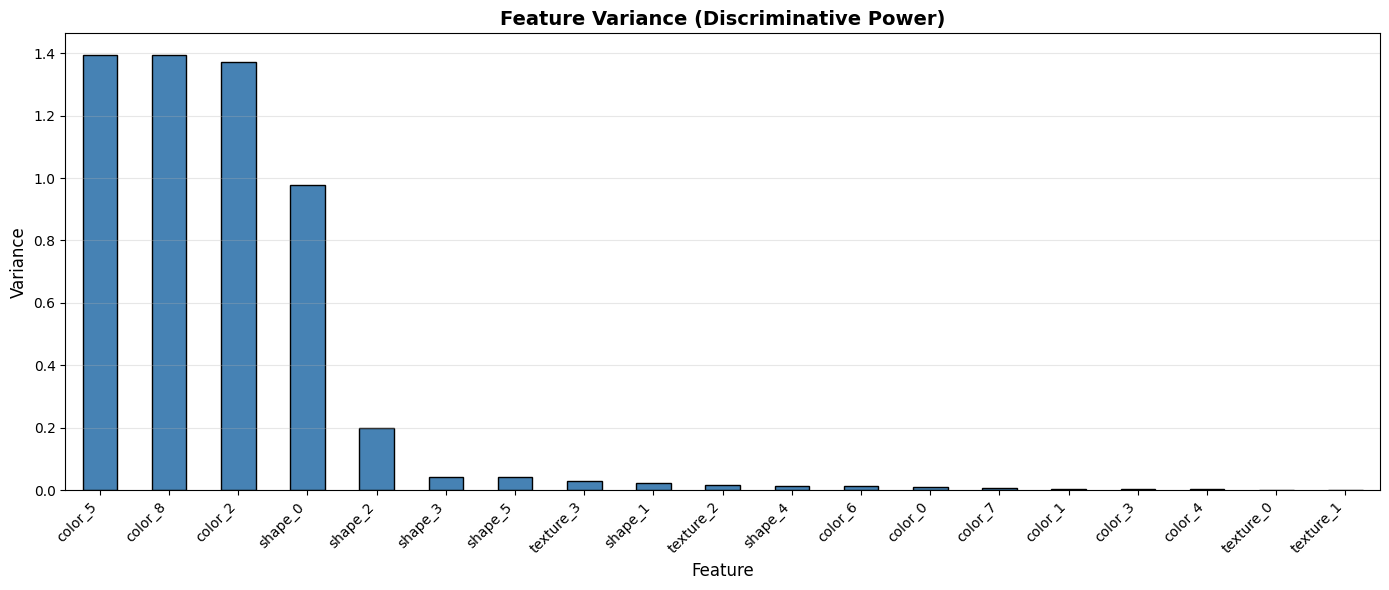

In [7]:
# Calculer variance de chaque feature
variances = X_features.var().sort_values(ascending=False)
print("\nTop 10 features avec plus de variance:")
print(variances.head(10))

# Visualiser
plt.figure(figsize=(14, 6))
variances.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.title('Feature Variance (Discriminative Power)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FEATURES_DIR / 'features_variance.png', dpi=200)
plt.show()


# 6. SAUVEGARDER LES FEATURES

In [8]:
# Sauvegarder tout
df_features.to_csv(FEATURES_DIR / 'all_features.csv', index=False)
print(f"\n Features sauvegardées: {FEATURES_DIR / 'all_features.csv'}")

# Sauvegarder par split (pour faciliter le loading)
for split in ['train', 'val', 'test']:
    df_split = df_features[df_features['split'] == split]
    df_split.to_csv(FEATURES_DIR / f'{split}_features.csv', index=False)
    print(f" {split.capitalize()}: {len(df_split)} samples")



 Features sauvegardées: ../data/features/all_features.csv
 Train: 1525 samples
 Val: 191 samples
 Test: 191 samples


# 7. VISUALISER QUELQUES EXEMPLES

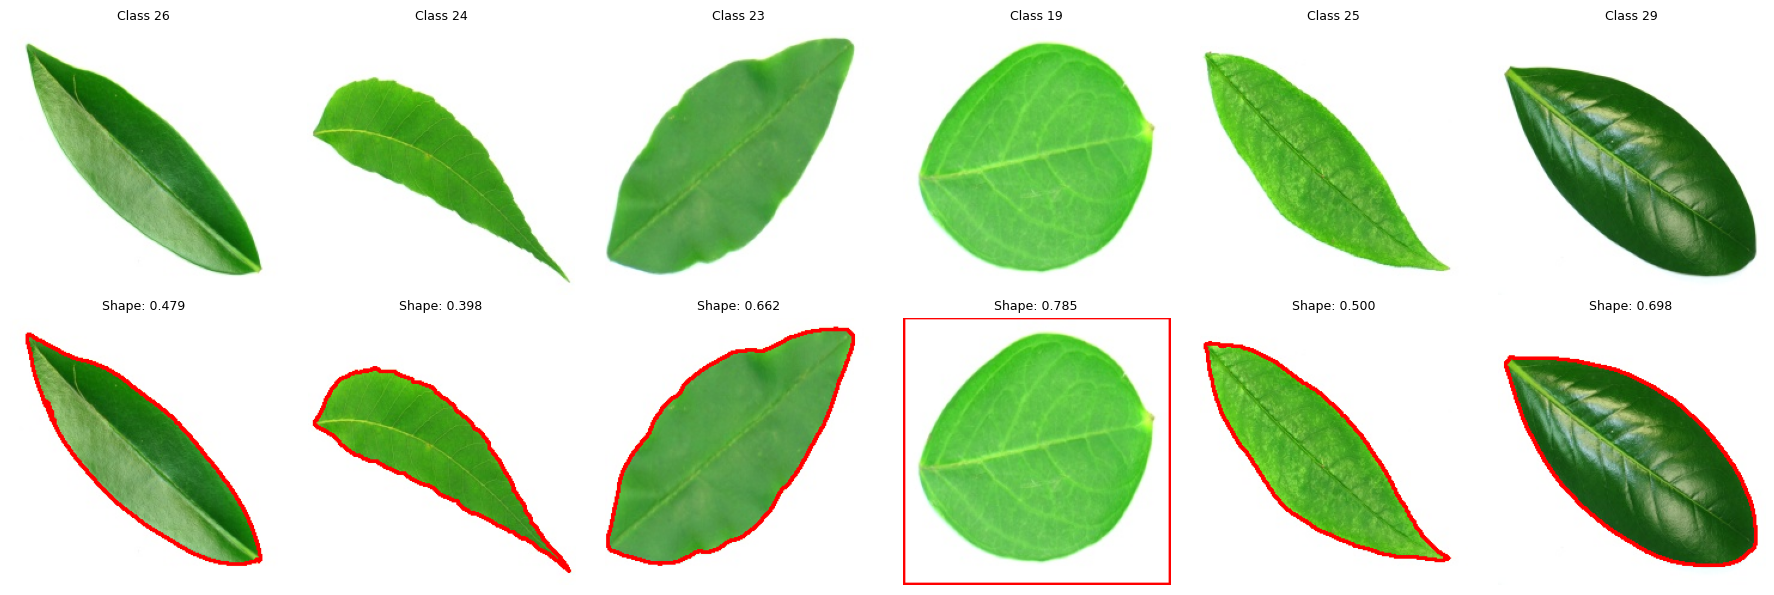


✅ FEATURE EXTRACTION TERMINÉE !

📁 Fichiers créés:
   - all_features.csv (1907 × 22)
   - train_features.csv (1525 samples)
   - val_features.csv (191 samples)
   - test_features.csv (191 samples)


In [9]:
# Prendre 6 images aléatoires
sample_rows = df_features[df_features['split'] == 'train'].sample(6, random_state=42)

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i, (idx, row) in enumerate(sample_rows.iterrows()):
    filename = row['filename']
    label = row['label']
    
    # Charger image
    img_path = PROCESSED_DIR / 'train' / f'class_{label:02d}' / filename
    img_rgb = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    # Original
    axes[0, i].imshow(img_rgb)
    axes[0, i].set_title(f'Class {label}', fontsize=9)
    axes[0, i].axis('off')
    
    # Contour (shape features)
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(binary) > 127:
        binary = cv2.bitwise_not(binary)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contour = img_rgb.copy()
    if contours:
        cv2.drawContours(img_contour, contours, -1, (255, 0, 0), 2)
    
    axes[1, i].imshow(img_contour)
    axes[1, i].set_title(f'Shape: {row["shape_5"]:.3f}', fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(FEATURES_DIR / 'feature_extraction_examples.png', dpi=200)
plt.show()

print("\n" + "=" * 60)
print("✅ FEATURE EXTRACTION TERMINÉE !")
print("=" * 60)
print(f"\n📁 Fichiers créés:")
print(f"   - all_features.csv (1907 × 22)")
print(f"   - train_features.csv (1525 samples)")
print(f"   - val_features.csv (191 samples)")
print(f"   - test_features.csv (191 samples)")

### Features Extraites (19 features) 📊  

| Type    | Count | Exemples                          | Qualité                      |
|---------|-------|-----------------------------------|------------------------------|
| Shape   | 6     | area, perimeter, compactness      | ✅ Bonne variance            |
| Color   | 9     | RGB moments (mean, std, skewness) | ✅ Très discriminantes       |
| Texture | 4     | contrast, entropy, energy         | ✅ Moyennement discriminantes|


🥇 color_5 (skewness canal G) : variance 1.39  ← TRÈS DISCRIMINANT  
🥈 color_8 (skewness canal B) : variance 1.39  
🥉 color_2 (skewness canal R) : variance 1.37  
4️⃣ shape_0 (area)             : variance 0.98  
5️⃣ shape_2 (aspect ratio)     : variance 0.20  

#### Observation Clé : Les features de couleur (color_*) sont BEAUCOUP plus discriminantes que shape et texture !

Pourquoi ?  

* Feuilles de différentes espèces = couleurs différentes (vert clair, vert foncé, bleuté, etc.)
* Forme peut être similaire entre espèces (ovale, lancéolée)

## Observation sur les Contours (rouge) :

| Classe   | Forme (Compactness) | Type de Feuille                  |
|----------|---------------------|----------------------------------|
| Class 26 | 0.479               | Lancéolée (pointue)              |
| Class 24 | 0.398               | Asymétrique                      |
| Class 23 | 0.662               | Ovale                            |
| Class 19 | 0.785               | Quasi-circulaire (Ginkgo biloba!)|
| Class 25 | 0.500               | Lancéolée avec dentelures        |
| Class 29 | 0.698               | Elliptique                       |


✅ Le feature shape_5 (compactness) capture bien la forme !

Ginkgo (0.785) = très rond  
Class 24 (0.398) = très irrégulier  

#### Distribution des Features  
Features normalisées correctement

shape_0:  mean=1.70, std=0.99  ✅  
color_0:  mean=0.77, std=0.09  ✅ (normalized 0-1)  
texture_0: mean=0.09, std=0.04 ✅  
Pas besoin de re-normaliser ! Toutes les features sont déjà bien scaled